In [221]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astropy.table import Table

In [222]:
plt.style.use("seaborn-talk")

In [31]:
simbadtap = vo.dal.TAPService("http://simbad.u-strasbg.fr/simbad/sim-tap")

In [173]:
# get all tables
# tables method parses the response of /tables,
# but it will result in exception due to a possible bug in astropy.io.votable
# You can also just query the database for this info
result = simbadtap.run_sync(
    "select * from TAP_SCHEMA.tables where schema_name not like 'tap_schema'")

In [35]:
result.table

description,schema_name,table_name,table_type,utype
object,object,object,object,object
General data about an astronomical object,public,basic,table,
List of all object types associated with an object,public,otypes,table,
all names concatenated with pipe,public,ids,view,
all object types concatenated with pipe,public,alltypes,view,
all names and definitions for the object types,public,otypedef,table,
Identifiers of an astronomical object,public,ident,table,
Catalogues name,public,cat,table,
Magnitude/Flux information about an astronomical object,public,flux,table,
"all flux/magnitudes U,B,V,I,J,H,K,u_,g_,r_,i_,z_",public,allfluxes,view,


The relevant table for RV measurements is `mesVelocities`. We also need `ident` table which has
two columns, `oidref` and `id` where `oidref` is unique internally, and `id` is all possible known
names of sources. we use `oidref` to crossmatch tables.

In [75]:
rows = []
for col in simbadtap.run_sync("select top 0 * from mesVelocities").table.itercols():
    rows.append([col.name, col.dtype.str, col.description])
mesVelocitiesMeta = Table(rows=rows, names=['colname', 'dtype','description'])
mesVelocitiesMeta

colname,dtype,description
str14,str3,str71
bibcode,|O,measurement bibcode
d,|S1,'D' if the resolution is a conversion from the dispersion
meanError,<f4,sigma(Value)
meanError_prec,<i2,Precision (# of decimal positions) associated with the column meanError
mespos,<i2,Position of a measurement in a list of measurements
nature,|O,nature of the measurement
nbmes,<i2,Number of measurements
obsdate,<f8,Observation date
obsdate_prec,<i2,Precision (# of decimal positions) associated with the column obsdate


We query by HIP or TYC identifiers.

In [40]:
df = groupten.load_allstars()
tgas = gwb.TGASData("/Users/semyeong/data/gaia/tgas_source/stacked_tgas.fits")

In [51]:
hips = tgas.hip[df.tgas_row]
tycs = np.array([s.decode() for s in tgas.tycho2_id[df.tgas_row]]).byteswap().newbyteorder()

In [54]:
idens = ['HIP {:d}'.format(h) if h!=999999 else 'TYC {:s}'.format(t) for h,t in zip(hips,tycs)]

In [94]:
identable = Table({'name':idens[:]})
identable.write("test.xml", format='votable', overwrite=True)

In [99]:
query = """
SELECT t.name, bibcode, nbmes, obsdate, qual, quality, velType, velValue, velValue_prec, remark, remarks, ident.oidref
FROM TAP_UPLOAD.mytable as t JOIN ident ON t.name = ident.id
JOIN mesVelocities ON mesVelocities.oidref = ident.oidref
"""

In [100]:
result = simbadtap.run_sync(query, uploads={"mytable":('inline', 'test.xml')})

In [101]:
len(identable)

10606

In [108]:
dfrv = result.table.to_pandas()

In [133]:
# decode all bytestrings
dfrv = dfrv.apply(lambda x: x.str.decode('utf-8') if x.dtype==object else x)

In [174]:
dfrv.to_csv("../data/star_rv.csv", index=False)

In [136]:
rvq = dfrv.groupby("name").quality.value_counts()
rvq  # has MultiIndex name and quality

name             quality
HIP 100035       A          2
HIP 100072       A          3
                 C          1
HIP 100179       B          1
HIP 100280       A          2
HIP 100321       A          2
                            1
                 E          1
HIP 100510       C          1
HIP 100941       D          1
                 E          1
HIP 101082                  4
                 A          2
                 C          2
HIP 101123       B          1
HIP 101166                  3
HIP 101460       B          1
HIP 101472       C          2
HIP 101673       A          1
HIP 101717       B          1
HIP 101719       D          1
HIP 101787       C          2
HIP 101889       B          2
HIP 101972                  1
                 D          1
HIP 102016       A          2
HIP 102018       A          3
                            1
                 C          1
HIP 102394       B          3
                           ..
TYC 9458-1022-1  C          1
TYC 9458-473-1 

In [148]:
dfrv.groupby("quality")['name'].describe()

quality        
         count                 744
         unique                438
         top        TYC 2342-544-1
         freq                   14
A        count                 508
         unique                360
         top            HIP 107362
         freq                    6
B        count                 864
         unique                709
         top       TYC 6166-1405-1
         freq                    4
C        count                 382
         unique                313
         top       TYC 7279-1345-1
         freq                    3
D        count                  89
         unique                 84
         top       TYC 8966-1241-1
         freq                    3
E        count                  31
         unique                 30
         top            HIP 109388
         freq                    2
Name: name, dtype: object

In [156]:
rvA = dfrv.loc[dfrv.quality == 'A'].groupby("name")

In [176]:
# see if multiple quality A measurements agree with each other
rvAmulti = rvA.filter(lambda x:x.bibcode.unique().size>1)

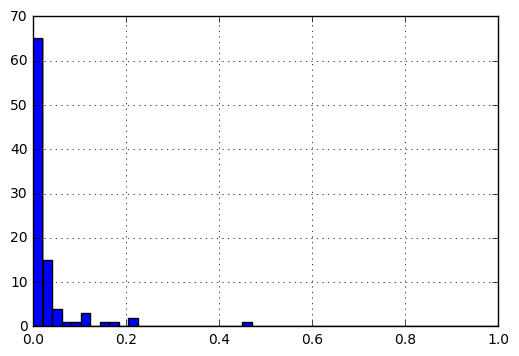

In [192]:
rvAmulti.groupby("name").velValue.agg(lambda x: np.abs((x.max()-x.min())/x.mean())).hist(bins=np.linspace(0,1,50))

/Users/semyeong/anaconda2/envs/gwb/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


(0.1, 10000.0)

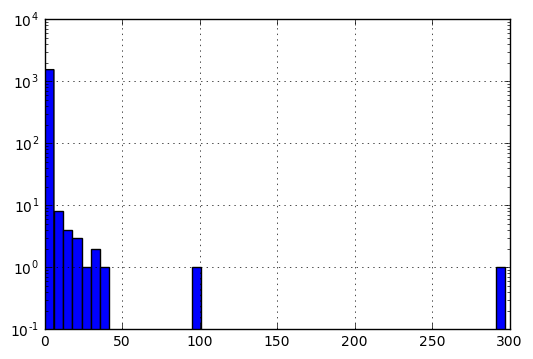

In [205]:
dfrv.groupby("name").velValue.agg(lambda x: np.abs((x.max()-x.min())/x.mean())).hist(bins=50, log=True)
plt.ylim(0.1)

In [193]:
# those that differ more than 10%
rvAmulti.groupby("name").filter(lambda x: np.abs(x.velValue.max()-x.velValue.min())/x.velValue.mean() > 0.1)

,name,bibcode,nbmes,obsdate,qual,quality,velType,velValue,velValue_prec,remark,remarks,oidref
322,HIP 107362,17AJ....153...7521K,1.0,53610.564,A,A,v,16.640000,2.0,,,3470803.0
323,HIP 107362,2013A&A...552A..64S,NaN,NaN,,A,z,19.374000,3.0,,,3470803.0
324,HIP 107362,2011AJ....141..187S,1.0,53609.000,A,A,v,18.619000,3.0,,,3470803.0
325,HIP 107362,2011AJ....141..187S,1.0,53609.000,A,A,v,16.644000,3.0,,,3470803.0
326,HIP 107362,2006AstL...32..759G,NaN,NaN,,A,V,18.000000,2.0,,,3470803.0
327,HIP 107362,2004A&A...418..989N,5.0,NaN,,A,v,19.299999,1.0,,,3470803.0
518,TYC 7464-1208-1,17AJ....153...7521K,1.0,53133.762,A,A,v,5.720000,2.0,,,2340062.0
519,TYC 7464-1208-1,2011AJ....141..187S,1.0,53132.000,A,A,v,5.722000,3.0,,,2340062.0
520,TYC 7464-1208-1,2008AJ....136..421Z,1.0,NaN,,A,v,7.100000,1.0,,,2340062.0
865,HIP 103480,2004A&A...418..989N,2.0,NaN,,A,v,3.300000,1.0,,,2507798.0


In [206]:
dfrv.remark.value_counts()

    2618
Name: remark, dtype: int64

In [207]:
dfrv.remarks.value_counts()

      2449
##     122
V       43
O        3
D        1
Name: remarks, dtype: int64

In [220]:
dfrv.loc[dfrv.quality=='A', 'bibcode'].value_counts()

17AJ....153...7521K    163
2004A&A...418..989N    100
2006AstL...32..759G     52
2007AJ....133.2524W     32
2011AJ....141..187S     28
2008AJ....136..421Z     21
2006A&A...460..695T     17
2013A&A...552A..64S     14
2005A&A...430..165F     10
2015A&A...573A.126D      9
2013MNRAS.435.1376M      8
2002AJ....124.1144L      8
2011AAS...21743412C      6
1997JApA...18..161Y      5
2002ApJS..141..503N      5
2006PASP..118.1656S      5
2007A&A...475..519H      3
1992A&A...256..121T      3
2008AJ....135..209M      2
2004A&A...424..727P      2
2005ApJS..159..141V      2
2012ApJ...745...56D      2
2013AJ....146..143M      2
2007A&A...465..271R      1
2014ApJ...788...81M      1
1992A&AS...95..541F      1
2004MNRAS.349.1069K      1
2012MNRAS.422...14H      1
2011yCat.3265....0S      1
2008A&A...480...91S      1
2013A&A...554A..84M      1
1953GCRV..C......0W      1
Name: bibcode, dtype: int64